<h1> GAN comparison on Scania Dataset </h1><br>
Development Notebook For generating dataset From Minority Cclass
<hr>

This notebook is adapted from 
<a href='https://www.toptal.com/machine-learning/generative-adversarial-networks'>here</a>.<br> and
<a href='https://www.toptal.com/machine-learning/generative-adversarial-networks'>here</a>.<br>
Data is available from IDA 2016 - Industrial Challenges at <a href='https://ida2016.blogs.dsv.su.se/?page_id=1387'>this link.</a><br>


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
# to display fully (non-truncated) data-frame
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # revert to 'last_expr' to get only last results

import sys # to make print statements work here

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
random_state = 42

### Check memory

In [2]:
import psutil 
import gc
gc.collect()
psutil.virtual_memory()
print(list(psutil.virtual_memory())[0:2])

26

svmem(total=17179869184, available=7455064064, percent=56.6, used=9370955776, free=2362032128, active=5019906048, inactive=4875612160, wired=4351049728)

[17179869184, 7455162368]


In [3]:
import xgboost as xgb
import pickle

# Load custom functions
import GANS

# For reloading after making changes
import importlib
importlib.reload(GANS) 
from GANS import *

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


<module 'GANS' from '/Users/Yasmin/Google Drive/PythonCam/ScaniaImbalancedData/GANS.py'>

## Load Dataset

In [4]:
# Load already engineered dataset from EDA section

#data = pickle.load(open('data/' + 'scania.engineered.pkl','rb')) 
#data = pd.read_csv("imp_mean164_aps_failure_training_set.csv")
#data = pd.read_csv("imp_mean165_aps_failure_training_set.csv")
# data_train = pd.read_csv("imp_mean_aps_failure_training_set.csv")
# data_test = pd.read_csv("imp_mean_aps_failure_test_set.csv")

data_dir ="ScaniaDataset/dimReduction/"
data_train = pd.read_csv(data_dir+"pca_aps_mean_failure_train_set.csv")
data_test =  pd.read_csv(data_dir+"pca_aps_mean_failure_test_set.csv")

# data_dir ="ScaniaDataset/imputation/"
# data_train = pd.read_csv(data_dir+"imp_aps_mean_failure_training_set.csv")
# data_test =  pd.read_csv(data_dir+"imp_aps_mean_failure_test_set.csv")

# data columns will be all other columns except class
data_cols = list(data_train.columns[data_train.columns != 'class' ])
label_cols = ['class']


print(data_cols)
print('# of data columns: ',len(data_cols))
print(data_train.shape)
print(data_test.shape)
data_train.head(3)

['pc_0', 'pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 'pc_6', 'pc_7', 'pc_8', 'pc_9', 'pc_10']
# of data columns:  11
(60000, 12)
(16000, 12)


pc_0      pc_1      pc_2      pc_3      pc_4      pc_5      pc_6      pc_7      pc_8      pc_9     pc_10  class
0 -0.357653  0.149168  0.785559  0.107379 -0.068720 -0.028512  0.128307  0.002902 -0.073669  0.079233 -0.019663  0    
1 -0.009868  0.178451 -0.153641 -0.106095  0.115751  0.677376  0.038713  0.021226  0.052543 -0.016909 -0.012898  0    
2  0.036263 -0.202770 -0.164386 -0.072079  0.131766 -0.043973 -0.051563 -0.000143  0.000497 -0.034116 -0.000904  0

### Percentage of each class in the dataset 
- 0 No failure
- 1 Failure

In [5]:
# 59000 with no failure (class 0)
# 1000 with failure (class 1)
print("Training:")
data_train['class'].value_counts()
data_train['class'].value_counts()/len(data_train)*100
print("\nTesting:")
data_test['class'].value_counts()
data_test['class'].value_counts()/len(data_test)*100

Training:


0    59000
1    1000 
Name: class, dtype: int64

0    98.333333
1    1.666667 
Name: class, dtype: float64


Testing:


0    15625
1    375  
Name: class, dtype: int64

0    97.65625
1    2.34375 
Name: class, dtype: float64

### Put columns in order of importance for xgboost scania (from that section)

In [6]:
#sorted_cols = xgb_important_features

sorted_cols = data_cols+label_cols
data_train = data_train[sorted_cols ].copy()


### Clustering the failure in Scania dataset - Creating two classes of failures using K-means

In [7]:
from sklearn.metrics import silhouette_score, silhouette_samples

In [8]:
# Add KMeans generated classes to failure data - see classification section for more details on this

import sklearn.cluster as cluster

train = data_train.loc[data_train['class']==1].copy()

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 
                  'random_state':random_state}

alg = algorithm(*args, **kwds)
labels = alg.fit_predict(train[data_cols])

print(pd.DataFrame([[np.sum(labels==i)] for i in np.unique(labels)], 
                    columns=['count'], index=np.unique(labels) ) )

train_failure_w_classes = train.copy()
train_failure_w_classes['class'] = labels

silhouette_score(train[data_cols], labels)

# get silhouette for each cluster
sample_silhouette_values = silhouette_samples(train[data_cols], labels)

cluster_labels = alg.labels_
sil_lbl_dict = {}
for label in range(2):
    sil_lbl_dict[label] =(sample_silhouette_values[cluster_labels == label].mean())
    
print(sil_lbl_dict)

   count
0  390  
1  610  


0.2646115713207404

{0: 0.12344473812712868, 1: 0.35486577614944304}


### Exploratory Data Analysis (EDA)

### Total Nulls in dataset (sum over rows, then over columns)

In [9]:
data_train.isnull().sum().sum()

0

### Check duplications in the dataset for all classes i.e. failure/no failure

In [10]:
# Duplicates? No

def check_duplicates(df):
    normal_duplicates = sum(df.loc[df['class']==0].duplicated())
    failure_duplicates = sum(df.loc[df['class']==1].duplicated())
    total_duplicates = normal_duplicates + failure_duplicates

    print( 'Normal duplicates', normal_duplicates )
    print( 'Failure duplicates', failure_duplicates )
    print( 'Total duplicates', total_duplicates )
    print( 'Failure duplicated', total_duplicates / len(df))
    
print("Trainning:")
check_duplicates(data_train)
print("\nTesting")
check_duplicates(data_test)

Trainning:
Normal duplicates 1
Failure duplicates 0
Total duplicates 1
Failure duplicated 1.6666666666666667e-05

Testing
Normal duplicates 0
Failure duplicates 0
Total duplicates 0
Failure duplicated 0.0


### Check skewness in the data

In [11]:
data_train.skew()

pc_0     1.663576
pc_1     0.796523
pc_2     1.701377
pc_3     4.993711
pc_4     0.717977
pc_5     3.371760
pc_6    -0.096262
pc_7     0.182056
pc_8     0.179834
pc_9     1.063552
pc_10    2.509902
class    7.551146
dtype: float64

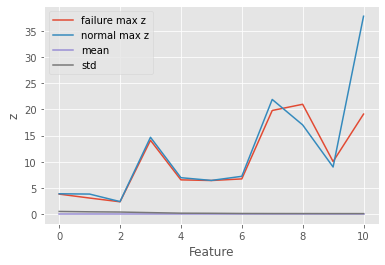

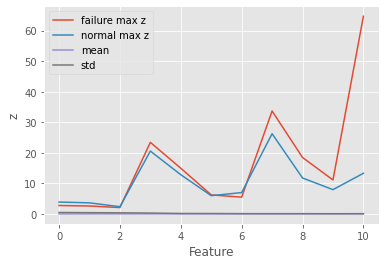

In [12]:
# There are outliers, 50-100 stdevs away from mean in several columns

def plot_data(df):
    plot_cols = data_cols
    # plt.plot( np.log10( data[ plot_cols ].abs().max().values ) )
    # plt.plot( data[ plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='max z/10' )
    plt.plot(df.loc[df['class']==1, plot_cols ].abs().max().values / df[plot_cols ].std().values, label='failure max z' )
    plt.plot(df.loc[df['class']==0, plot_cols ].abs().max().values / df[plot_cols ].std().values, label='normal max z' )
    plt.plot(df[ plot_cols ].mean().values, label='mean' )
    # plt.plot( data[ plot_cols ].abs().mean().values, label='abs mean' )
    plt.plot(df[ plot_cols ].std().values, label='std' )
    plt.xlabel('Feature')
    plt.ylabel('z')
    plt.legend()
    plt.show();

plot_data(data_train)
plot_data(data_test)

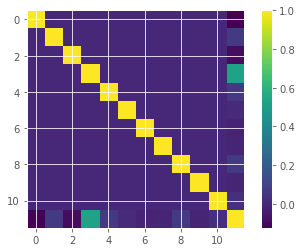

In [13]:
# Check Correlations
corr0 = data_train.corr()
plt.imshow(corr0)
plt.colorbar();

In [14]:
# Total nulls in dataset (sum over rows, then over columns)
data_train.isnull().sum().sum()
data_test.isnull().sum().sum()

0

0

<a id="Fig1"><h1>Figure 1: Data Distributions by Feature and Failure/Normal Class</h1></a><br>
<a href='#TOC'>Table of contents</a>

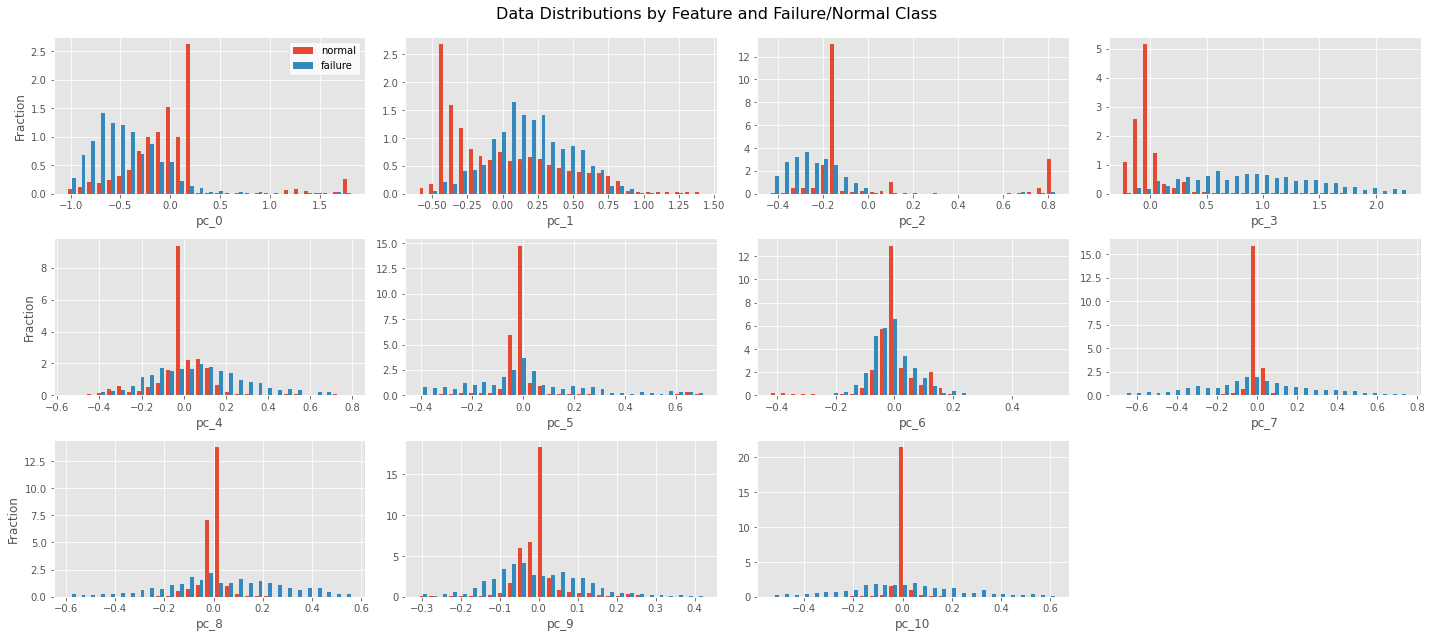

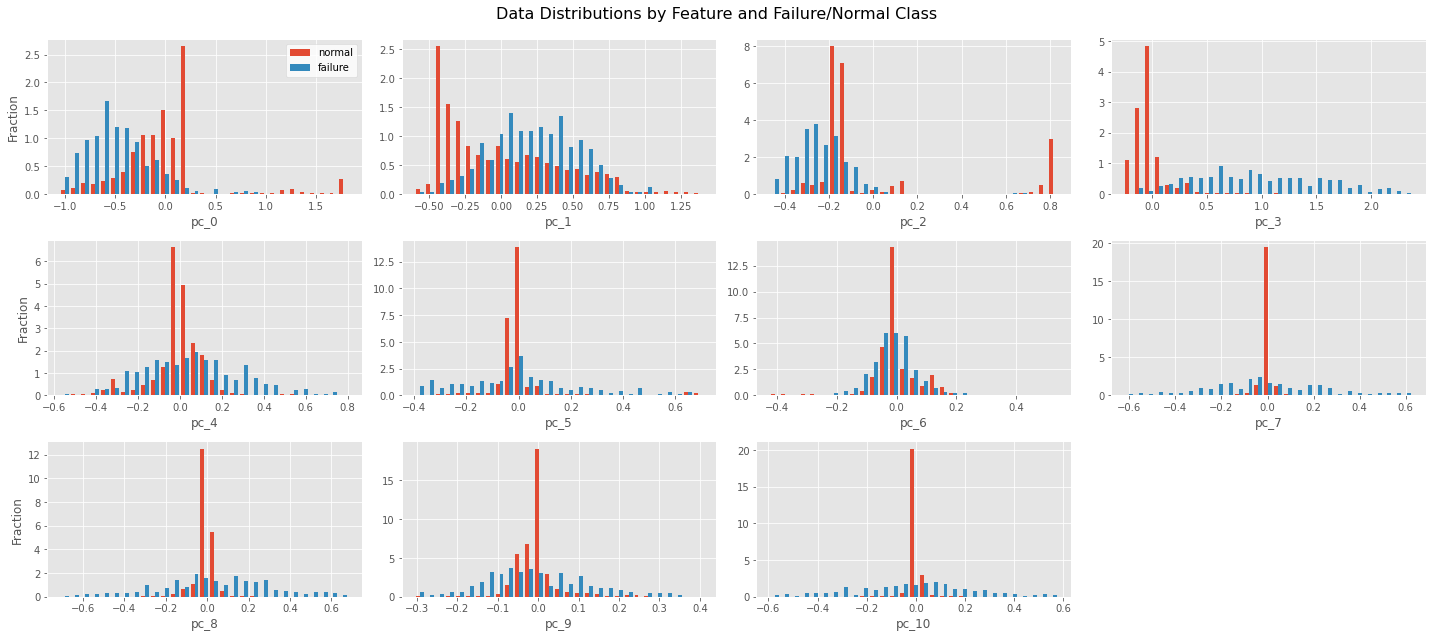

In [15]:
def plot_data_features(df, fig_name='plots/Scanis_Engineered_Data_Distributions.png'):
    # Plot the data by each feature
    axarr = [[]]*len(data_cols)
    columns = 4
    rows = int(np.ceil(len(data_cols)/columns))
    # f, fig = plt.subplots(figsize=(columns*3.5, rows*2) )
    f, fig = plt.subplots(figsize=(columns*5, rows*3) )

    f.suptitle('Data Distributions by Feature and Failure/Normal Class', size=16)

    for i, col in enumerate(data_cols[:]):
        axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
    #     print((int(i//columns), int(i%columns)))
        axarr[i].hist([df.loc[ df['class'] == 0, col ], 
                       df.loc[ df['class'] == 1, col ] ], 
                       label=['normal','failure'], bins=np.linspace( np.percentile(df[col],0.1), 
                                                                    np.percentile(df[col],99.9), 30 ), density=True )
        axarr[i].set_xlabel(col, size=12)
    #     axarr[i].set_ylim([0,0.8])
    #     axarr[i].set_ylim([0,1.5])
        axarr[i].tick_params(axis='both', labelsize=10)
        if i == 0: 
            legend = axarr[i].legend()
            legend.get_frame().set_facecolor('white')
        if i%4 != 0 : 
            axarr[i].tick_params(axis='y', left='off', labelleft='off')
        else:
            axarr[i].set_ylabel('Fraction',size=12)

    plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
    plt.savefig(fig_name)
    plt.show()
    pass;
plot_data_features(data_train,fig_name='plots/Scanis_Engineered_Train_Distributions.png')
plot_data_features(data_test,fig_name='plots/Scanis_Engineered_Test_Distributions.png')

In [16]:
# Save engineered dataset as pickle for use in analysis
# pickle.dump(data_train, open('data/' + 'scania.train.engineered.pkl','wb'))
# pickle.dump(data_test, open('data/' + 'scania.test.engineered.pkl','wb'))
# Save as csv for human readability - much slower save
#data.to_csv('data/' + 'scania.engineered.csv.zip')

In [17]:
# Total nulls in dataset (sum over rows, then over columns)
data_train.isnull().sum().sum()
data_test.isnull().sum().sum()

0

0

### Clustering

In [18]:
# load clustering libraries

import sklearn.cluster as cluster
#!pip install hdbscan
import hdbscan

from sklearn.metrics import silhouette_score
from collections import Counter, OrderedDict
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import SpectralClustering

from sklearn.cluster import Birch
from sklearn.cluster import MeanShift

from sklearn.mixture import GaussianMixture

In [19]:

# Set up training set to consist of only fraud data

train = data_train.loc[ data_train['class']==1 ].copy()

print( pd.DataFrame( [ [np.sum(train['class']==i)] for i in np.unique(train['class']) ], columns=['count'], index=np.unique(train['class']) ) )

# train = pd.get_dummies(train, columns=['Class'], prefix='Class')
label_cols = [ i for i in train.columns if 'class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train_no_label = train[ data_cols ]


   count
1  1000 


In [20]:
# Total nulls in dataset (sum over rows, then over columns)
train.isnull().sum().sum()
train_no_label.isnull().sum().sum()

0

0

In [21]:
%%time

# TSNE is an interesting method to map higher dimensional data into two dimensions
# http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

# Note TSNE map may not be what you might think:
# https://distill.pub/2016/misread-tsne/

# Create multiple projections to compare results from different random states

from sklearn.manifold import TSNE

train_no_label = train_no_label.apply(pd.to_numeric)
projections = [ TSNE(random_state=i, n_components=2).fit_transform(train_no_label) for i in range(3) ]
# projections = [ TSNE(random_state=i, n_iter=2000).fit_transform(train_no_label) for i in range(3) ]



CPU times: user 1min 25s, sys: 2.83 s, total: 1min 28s
Wall time: 8.26 s


In [22]:
import hdbscan
from sklearn.metrics import silhouette_score
from collections import Counter

spectral clustering 0.37981930079774867
Counter({1: 908, 0: 92})
{0: 0.27040931742591257, 1: 0.39090489382661314}
Birch 0.23920610343933768
Counter({1: 678, 0: 322})
{0: 0.13940692476012415, 1: 0.28660335349052757}
Meanshift 0.38555221224683106
Counter({0: 989, 1: 11})
{0: 0.38505432545752843, 1: 0.4303167608486733}
KMeans  0.2646115713207404
Counter({0: 610, 1: 390})
{0: 0.35486577614944304, 1: 0.12344473812712868}
KMeans full 0.2646115713207404
Counter({1: 610, 0: 390})
{0: 0.12344473812712868, 1: 0.35486577614944304}
KMeans elkan 0.2646115713207404
Counter({1: 610, 0: 390})
{0: 0.12344473812712868, 1: 0.35486577614944304}
KMeans 0.2646115713207404
Counter({1: 610, 0: 390})
{0: 0.12344473812712868, 1: 0.35486577614944304}
Agglomerative 0.24096501084969055
Counter({0: 718, 1: 282})
{0: 0.27650101659179466, 1: 0.15048681183256027}
Agg. Ave 2 0.3674872078994707
Counter({0: 911, 1: 89})
{0: 0.37705751265566273, 1: 0.26952599854114545}
Agg. Single 2 0.4330702562030309
Counter({0: 995, 1: 

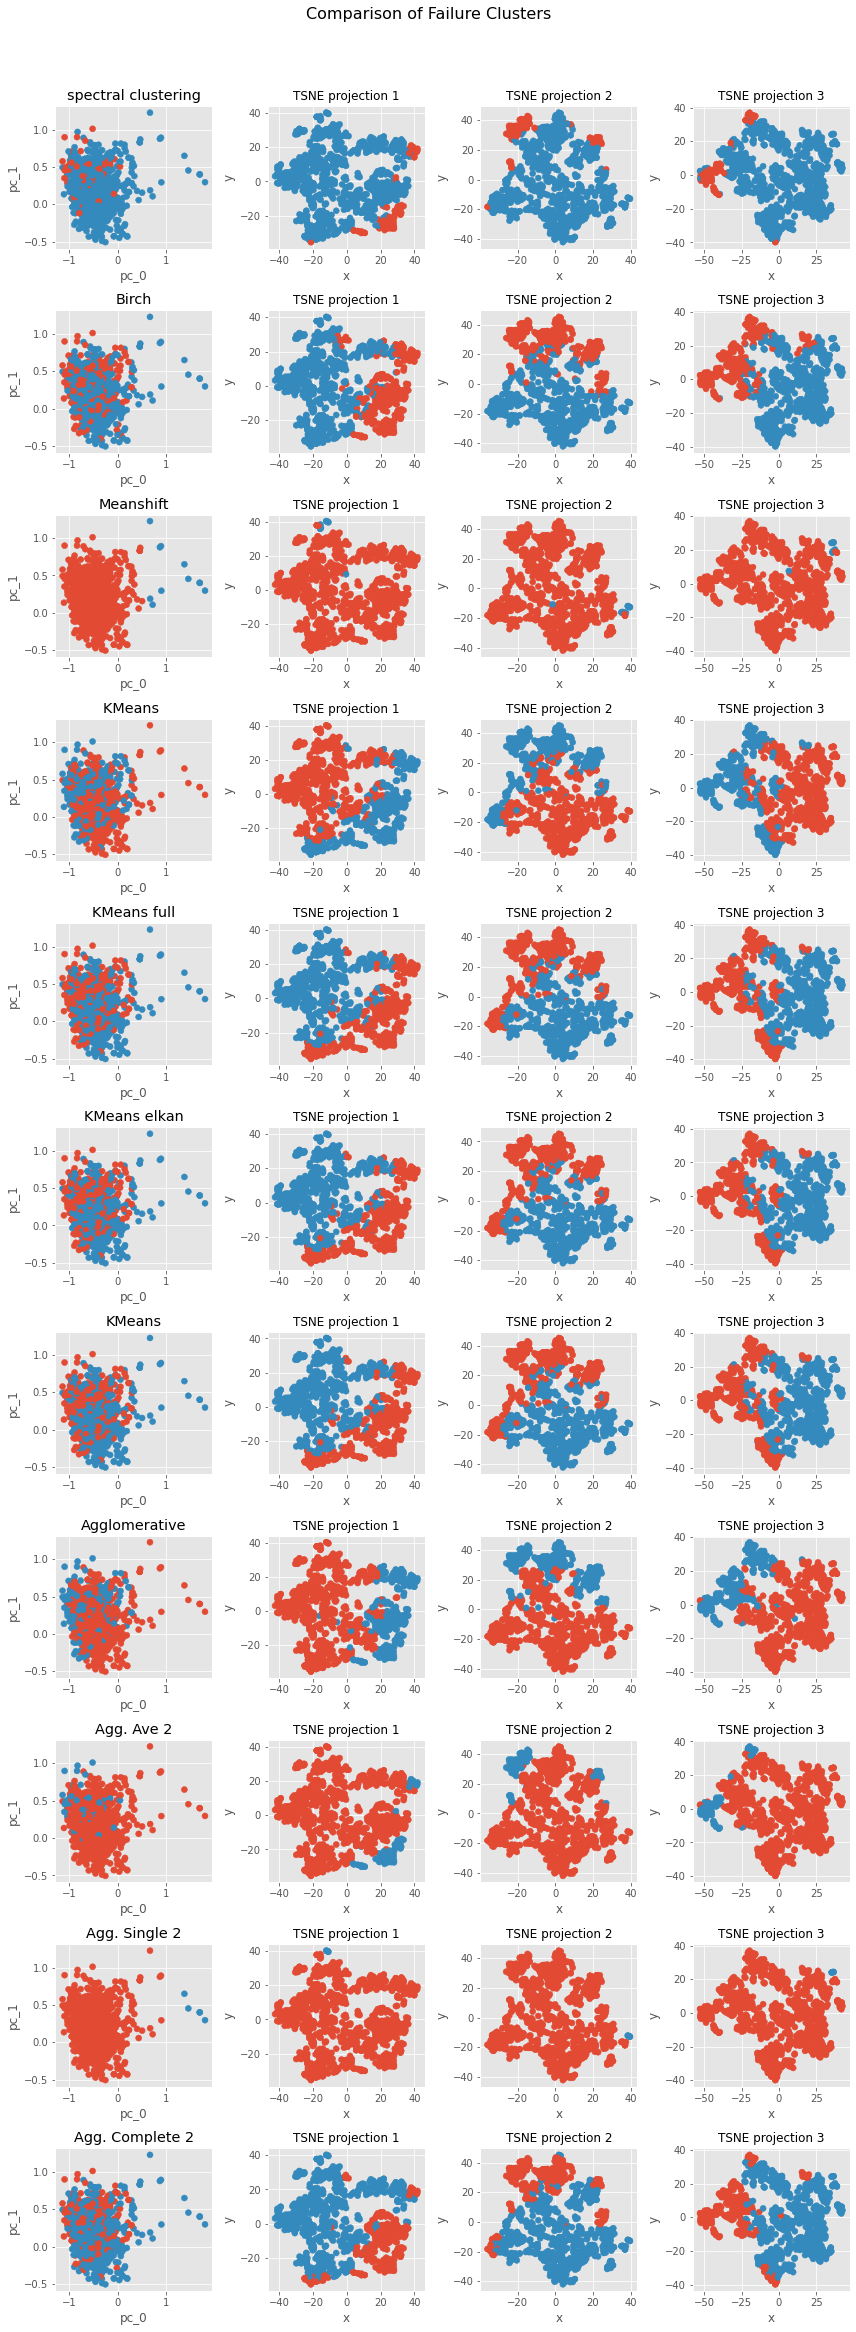

CPU times: user 21.6 s, sys: 2.14 s, total: 23.7 s
Wall time: 14.7 s


In [23]:
%%time 


# Now we'll compare some different clustering algorithms
# https://github.com/scikit-learn-contrib/hdbscan/blob/master/docs/comparing_clustering_algorithms.rst

algorithms = [ 
#     ['gaussian', GaussianMixture,(), {'n_components':2}],
    ['spectral clustering', SpectralClustering, (), {'n_clusters':2}],
    ['Birch', Birch,(), {'n_clusters':2}],
    ['Meanshift', MeanShift,(), {}],
    ['KMeans ', cluster.KMeans, (), {'n_clusters':2}],
     [ 'KMeans full', cluster.KMeans, (), {'n_clusters':2, 'random_state':random_state,'algorithm':'full'}],
     [ 'KMeans elkan', cluster.KMeans, (), {'n_clusters':2, 'random_state':random_state,'algorithm':'elkan'}],
    [ 'KMeans', cluster.KMeans, (), {'n_clusters':2, 'random_state':random_state} ],
   # [ 'KMeans 3', cluster.KMeans, (), {'n_clusters':3, 'random_state':ranrandom_state} ],
#     [ 'Agglomerative', cluster.AgglomerativeClustering, (), {} ],
    [ 'Agglomerative', cluster.AgglomerativeClustering, (), {'linkage': 'ward', 'n_clusters': 2} ],
#     [ 'Agglomerative 3', cluster.AgglomerativeClustering, (), {'linkage': 'ward', 'n_clusters': 3} ],
      [ 'Agg. Ave 2', cluster.AgglomerativeClustering, (), {'linkage': 'average', 'n_clusters': 2} ],
      ['Agg. Single 2', cluster.AgglomerativeClustering, (), {'linkage': 'single', 'n_clusters': 2} ],
      [ 'Agg. Complete 2', cluster.AgglomerativeClustering, (), {'linkage': 'complete', 'n_clusters': 2} ],
#      [ 'Agg. Ave 3', cluster.AgglomerativeClustering, (), {'linkage': 'average', 'n_clusters': 2} ],
#     [ 'Agg. Complete 3', cluster.AgglomerativeClustering, (), {'linkage': 'complete', 'n_clusters': 2} ],
#     ['Agg. Single 3', cluster.AgglomerativeClustering, (), {'linkage': 'single', 'n_clusters': 2} ],
#     [ 'Agg. Complete 3', cluster.AgglomerativeClustering, (), {'linkage': 'complete', 'n_clusters': 2} ]
#     [ 'Agg. Complete 3', cluster.AgglomerativeClustering, (), {'linkage': 'complete', 'n_clusters': 2} ],
#      [ 'DBSCAN', cluster.DBSCAN, (), {'eps':0.05} ],
# #     [ 'HDBSCAN', hdbscan.HDBSCAN, (), {} ],
#      [ 'HDBSCAN', hdbscan.HDBSCAN, (), {'min_cluster_size':10, 'min_samples':1} ],
#      [ 'HDBSCAN 2 10', hdbscan.HDBSCAN, (), {'min_cluster_size':2, 'min_samples':10, } ],
#      [ 'HDBSCAN 3 10', hdbscan.HDBSCAN, (), {'min_cluster_size':3, 'min_samples':10, } ],
#       [ 'HDBSCAN 10 10 ', hdbscan.HDBSCAN, (), {'min_cluster_size':10, 'min_samples':10, } ]
]

rows = len(algorithms)
columns = 4
plt.figure(figsize=(columns*3, rows*3))

for i, [name, algorithm, args, kwds] in enumerate(algorithms):
#     print(i, name)
    alg = algorithm(*args, **kwds)
    # train_no_label.iloc[:,1:3]
    labels = alg.fit_predict(train_no_label)
    silhouette_avg = silhouette_score(train_no_label, labels)
    print(name, silhouette_avg)
    print(Counter(alg.labels_))
    
    # get silhouette values for each cluster
    # get silhouette for each cluster
    sample_silhouette_values = silhouette_samples(train_no_label, labels)

    cluster_labels = alg.labels_
    sil_lbl_dict = {}
    for label in range(2):
        sil_lbl_dict[label] =(sample_silhouette_values[cluster_labels == label].mean())

    print(sil_lbl_dict)
    print(''.join(["="]*10))
#     labels = algorithm(*args, **kwds).fit_predict(projections[0])
    
#     print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )
    
    colors = np.clip(labels,-1,9)
    colors = [ 'C'+str(i) if i>-1 else 'black' for i in colors ]
    
    plt.subplot(rows,columns,i*columns+1)
    plt.scatter(train_no_label[data_cols[0]], train_no_label[data_cols[1]], c=colors)
    plt.xlabel(data_cols[0]), plt.ylabel(data_cols[1])
    plt.title(name)
 
    for j in range(3):
        plt.subplot(rows,columns,i*columns+1+j+1)
        plt.scatter(*(projections[j].T), c=colors) 
        plt.xlabel('x'), plt.ylabel('y')
        plt.title('TSNE projection '+str(j+1),size=12)
#         ax = Axes3D(fig)
#         colors = ['b', 'r']
#         labels = ['Failure1', 'Failure2']

#         for i, c, label in zip(range(len(labels)), colors, labels):
#               ax.scatter(*(projections[j].T), s=30, c=c, label=label, alpha=0.5)
#         fig.legend()
        
#     break

plt.suptitle('Comparison of Failure Clusters', size=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig('plots/Failure_Cluster_Diagram.png')
plt.show()

#Agg. Ave 2
#spectral clustering

In [24]:

# Now pick a set of labels and add to the dataset

#algorithm = cluster.KMeans
algorithm = cluster.AgglomerativeClustering
#args, kwds = (), {'n_clusters':2, 'random_state':random_state}
args, kwds = (),{'linkage': 'average', 'n_clusters': 2}
#args, kwds = (),{'linkage': 'single', 'n_clusters': 2}
labels = algorithm(*args, **kwds).fit_predict(train_no_label)
# labels = algorithm(*args, **kwds).fit_predict(projections[0])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

failure_w_classes = train.copy()
failure_w_classes['class'] = labels

silhouette_score(train_no_label, labels)

# get silhouette for each cluster
sample_silhouette_values = silhouette_samples(train_no_label, labels)

cluster_labels = alg.labels_
sil_lbl_dict = {}
for label in range(2):
    sil_lbl_dict[label] =(sample_silhouette_values[cluster_labels == label].mean())
    
print(sil_lbl_dict)

   count
0  911  
1  89   


0.3674872078994707

{0: 0.21404540100446653, 1: 0.4307711169578622}


In [25]:

# Let's see which features are most useful for detecting differences between the classes:

dtrain = xgb.DMatrix(failure_w_classes[data_cols], failure_w_classes['class'], feature_names=data_cols)

xgb_params = {
    'objective': 'binary:logistic',
    'random_state': random_state,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes 
    }
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10) # limit to ten rounds for fast evaluation

import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
print( 'Top eight features: ', [ [i[0],i[1]] for i in sorted_x[:8] ] )


Top eight features:  [['pc_3', 22], ['pc_10', 21], ['pc_4', 11], ['pc_1', 10], ['pc_9', 8], ['pc_5', 5], ['pc_8', 4], ['pc_6', 4]]


In [26]:
len(data_cols) # including class

11

<a id="GAN setup"><h1>GAN setup and training</h1></a>

<a href='#TOC'>Table of contents</a>


Resources:

https://github.com/wayaai/GAN-Sandbox
<br>
http://blog.richardweiss.org/2017/07/21/conditional-wasserstein-gan.html



Conversion of Waya.ai GAN and WGAN
- Remove convolutional layers
- Remove ResNeXt
- Add simple dense networks
- Convert WGAN back to simple GAN
- Use common functions as much as possible



For these functions I've passed the arguments as lists because it was easy to implement.

Standard solutions (because they are more stable) include using keyword dictionaries or objects, but those create a larger code base.


In [27]:
len(data_cols) 

11

In [28]:
# reloading the libraries and setting the parameters

import GANS
import importlib
importlib.reload(GANS) # For reloading after making changes
from GANS import *

rand_dim = len(data_cols)  # 32 # needs to be ~data_dim
base_n_count = 128 # 128

nb_steps = 5000 + 1 # 50000 # Add one for logging of the last interval
batch_size = 128 # 64

k_d = 1  # number of critic network updates per adversarial training step
k_g = 1  # number of generator network updates per adversarial training step
critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
learning_rate = 5e-4 # 5e-5
data_dir = 'cache/'
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

# show = False
show = True 

# train = create_toy_spiral_df(1000)
# train = create_toy_df(n=1000,n_dim=2,n_classes=4,seed=0)
train = failure_w_classes.copy().reset_index(drop=True) # fraud only with labels from classification

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

<module 'GANS' from '/Users/Yasmin/Google Drive/PythonCam/ScaniaImbalancedData/GANS.py'>

data_dim:  11
data_cols:  ['pc_0', 'pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 'pc_6', 'pc_7', 'pc_8', 'pc_9', 'pc_10']
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 11)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1536      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 11)                5643      
Total params: 171,787
Trainable params: 171,787
Non-traina

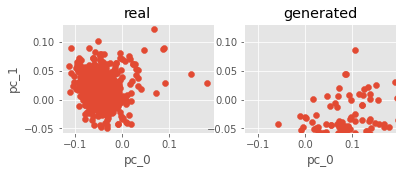

Step: 100 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0863, 0.0867, 0.0895, 0.8577
D Real - D Gen: 0.0028


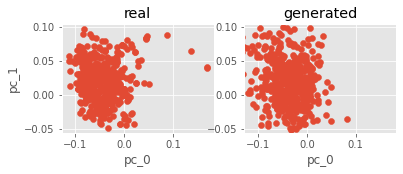

Step: 200 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0813, 0.0807, 0.0833, 0.8598
D Real - D Gen: 0.0025


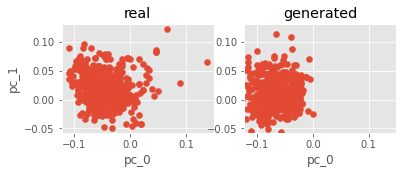

Step: 300 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0762, 0.0762, 0.0777, 0.7866
D Real - D Gen: 0.0015


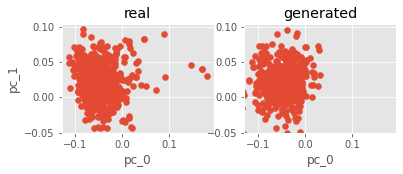

Step: 400 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0703, 0.0703, 0.0721, 0.7805
D Real - D Gen: 0.0017


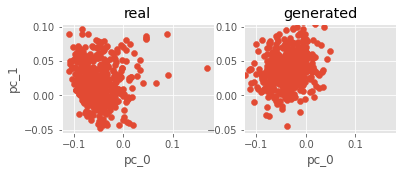

Step: 500 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0606, 0.0602, 0.0630, 0.8394
D Real - D Gen: 0.0028


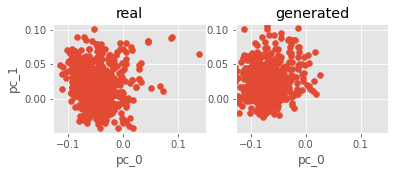

Step: 600 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0562, 0.0584, 0.0600, 0.8171
D Real - D Gen: 0.0016


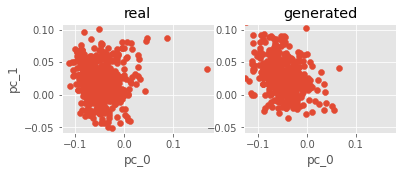

Step: 700 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0434, 0.0435, 0.0459, 0.8679
D Real - D Gen: 0.0024


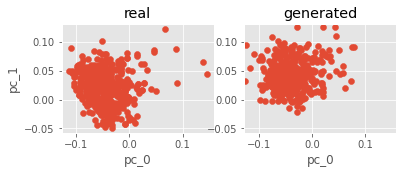

Step: 800 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0350, 0.0351, 0.0377, 0.9390
D Real - D Gen: 0.0027


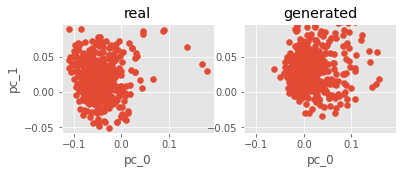

Step: 900 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0313, 0.0314, 0.0332, 0.9248
D Real - D Gen: 0.0018


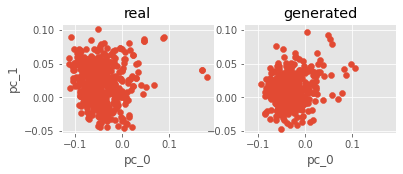

Step: 1000 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0397, 0.0393, 0.0408, 0.7947
D Real - D Gen: 0.0014


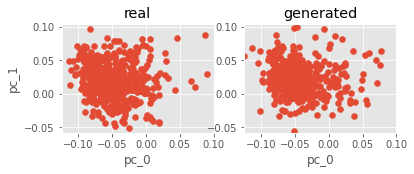

Step: 1100 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0305, 0.0300, 0.0333, 0.9045
D Real - D Gen: 0.0033


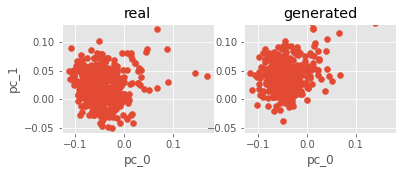

Step: 1200 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0322, 0.0323, 0.0323, 0.8841
D Real - D Gen: 0.0000


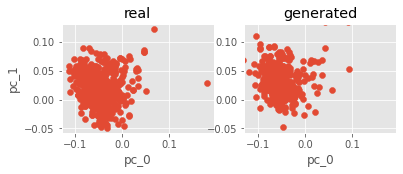

Step: 1300 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0270, 0.0268, 0.0279, 0.9390
D Real - D Gen: 0.0011


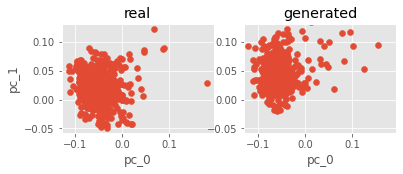

Step: 1400 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0231, 0.0229, 0.0251, 0.8780
D Real - D Gen: 0.0022


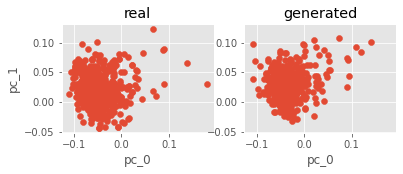

Step: 1500 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0157, 0.0158, 0.0185, 0.8902
D Real - D Gen: 0.0027


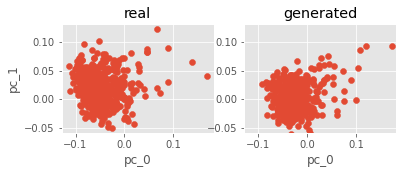

Step: 1600 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0139, 0.0151, 0.0154, 0.8923
D Real - D Gen: 0.0003


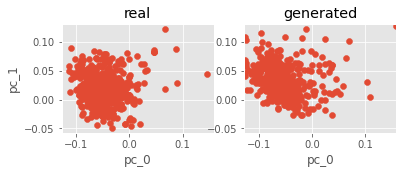

Step: 1700 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0162, 0.0162, 0.0165, 0.8496
D Real - D Gen: 0.0003


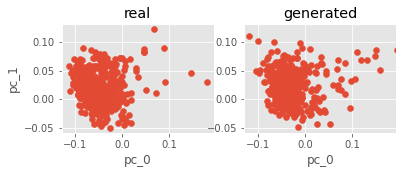

Step: 1800 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0237, 0.0226, 0.0242, 0.8841
D Real - D Gen: 0.0016


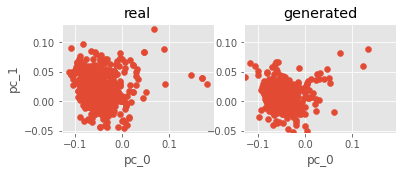

Step: 1900 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0162, 0.0166, 0.0179, 0.7866
D Real - D Gen: 0.0013


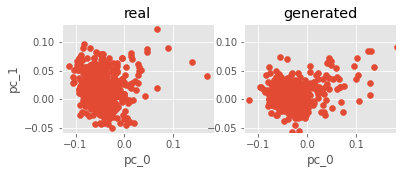

Step: 2000 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0156, 0.0149, 0.0166, 0.8049
D Real - D Gen: 0.0017


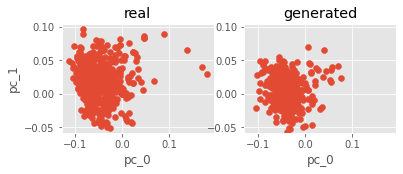

Step: 2100 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0154, 0.0152, 0.0166, 0.8272
D Real - D Gen: 0.0013


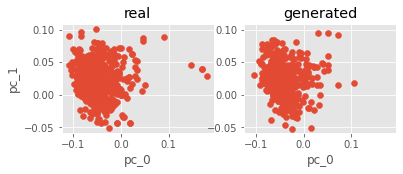

Step: 2200 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0075, 0.0076, 0.0077, 0.8780
D Real - D Gen: 0.0001


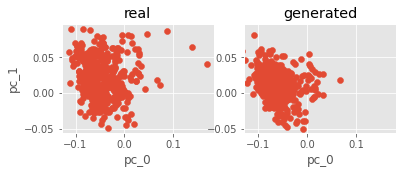

Step: 2300 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0249, 0.0242, 0.0247, 0.7398
D Real - D Gen: 0.0006


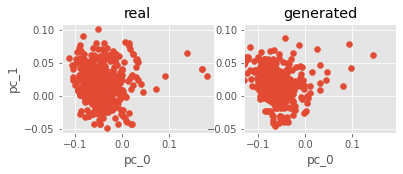

Step: 2400 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0232, 0.0223, 0.0242, 0.8191
D Real - D Gen: 0.0019


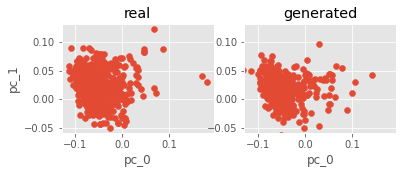

Step: 2500 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0134, 0.0131, 0.0142, 0.7561
D Real - D Gen: 0.0011


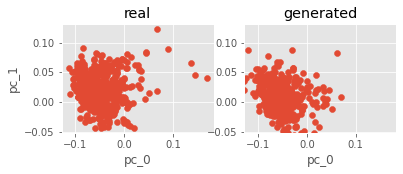

Step: 2600 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0224, 0.0215, 0.0223, 0.7825
D Real - D Gen: 0.0008


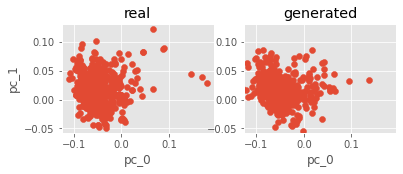

Step: 2700 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0325, 0.0318, 0.0335, 0.8069
D Real - D Gen: 0.0017


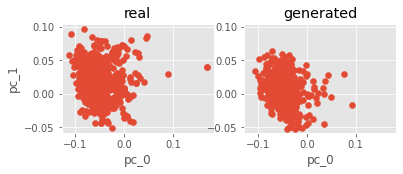

Step: 2800 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0198, 0.0198, 0.0214, 0.8740
D Real - D Gen: 0.0016


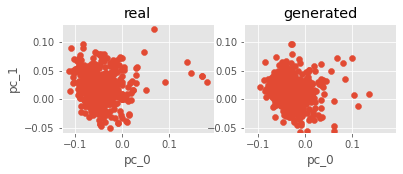

Step: 2900 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0362, 0.0358, 0.0366, 0.8089
D Real - D Gen: 0.0008


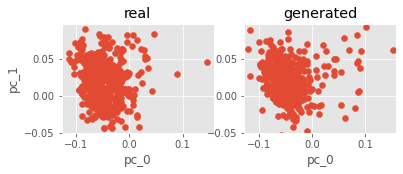

Step: 3000 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0396, 0.0391, 0.0400, 0.7724
D Real - D Gen: 0.0009


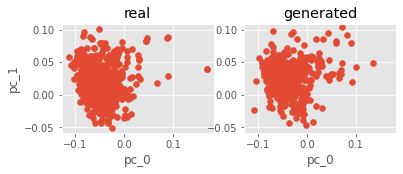

Step: 3100 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0357, 0.0365, 0.0357, 0.7805
D Real - D Gen: -0.0008


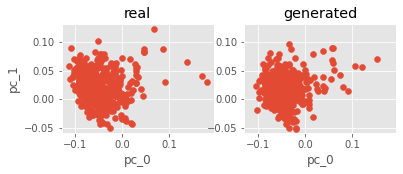

Step: 3200 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0267, 0.0266, 0.0268, 0.8699
D Real - D Gen: 0.0003


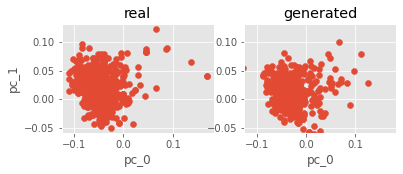

Step: 3300 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0208, 0.0196, 0.0209, 0.7724
D Real - D Gen: 0.0014


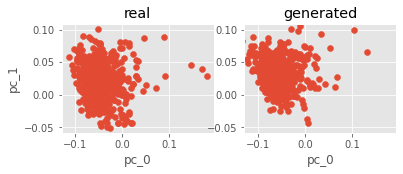

Step: 3400 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0120, 0.0117, 0.0129, 0.8374
D Real - D Gen: 0.0012


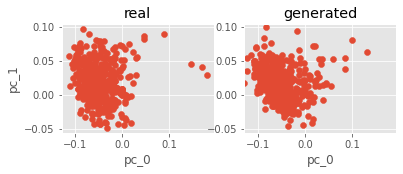

Step: 3500 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0155, 0.0157, 0.0159, 0.7439
D Real - D Gen: 0.0002


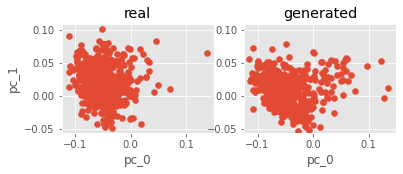

Step: 3600 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0021, 0.0028, 0.0031, 0.7033
D Real - D Gen: 0.0003


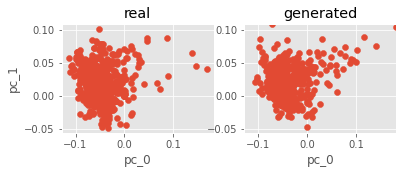

Step: 3700 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0143, 0.0143, 0.0148, 0.7297
D Real - D Gen: 0.0005


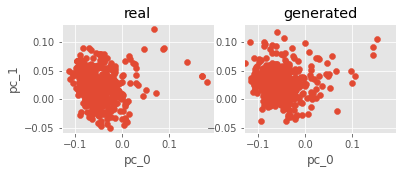

Step: 3800 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0120, 0.0117, 0.0116, 0.7520
D Real - D Gen: -0.0001


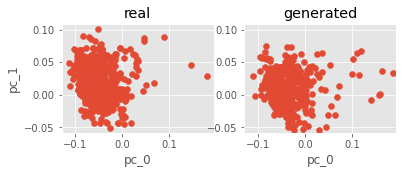

Step: 3900 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0153, 0.0151, 0.0162, 0.7439
D Real - D Gen: 0.0011


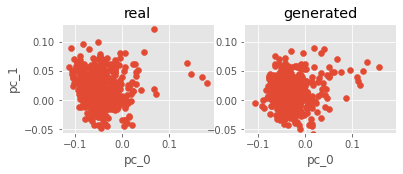

Step: 4000 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0103, 0.0097, 0.0107, 0.8171
D Real - D Gen: 0.0010


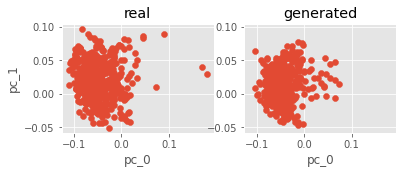

Step: 4100 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0099, 0.0095, 0.0098, 0.8760
D Real - D Gen: 0.0003


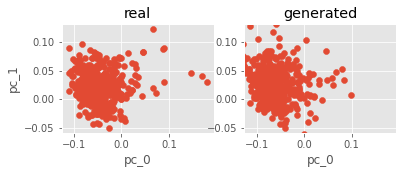

Step: 4200 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0175, 0.0167, 0.0170, 0.7317
D Real - D Gen: 0.0003


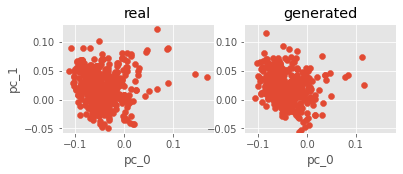

Step: 4300 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0157, -0.0160, -0.0153, 0.8008
D Real - D Gen: 0.0007


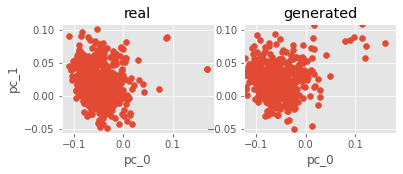

Step: 4400 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0128, -0.0129, -0.0125, 0.8313
D Real - D Gen: 0.0004


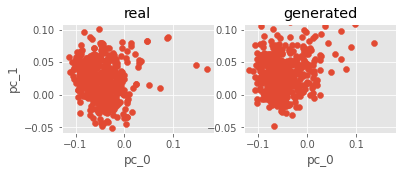

Step: 4500 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0034, 0.0030, 0.0042, 0.7297
D Real - D Gen: 0.0012


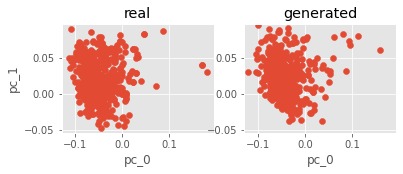

Step: 4600 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0202, 0.0201, 0.0201, 0.8476
D Real - D Gen: -0.0001


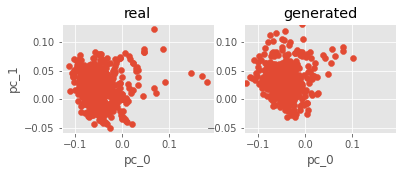

Step: 4700 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0294, 0.0293, 0.0293, 0.7886
D Real - D Gen: -0.0000


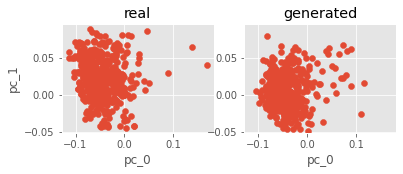

Step: 4800 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0306, 0.0304, 0.0305, 0.8293
D Real - D Gen: 0.0000


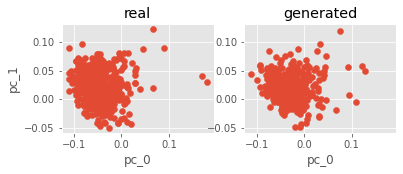

Step: 4900 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0270, 0.0273, 0.0286, 0.8272
D Real - D Gen: 0.0013


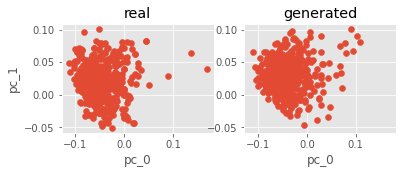

Step: 5000 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0297, 0.0297, 0.0293, 0.8293
D Real - D Gen: -0.0004


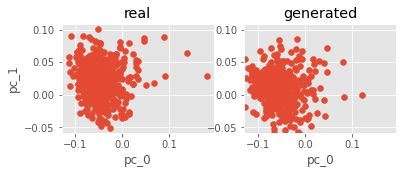

data_dim:  11
data_cols:  ['pc_0', 'pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 'pc_6', 'pc_7', 'pc_8', 'pc_9', 'pc_10']
label_dim:  1
label_cols:  ['class']
Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 12)           0           input_3[0][0]                    
                                                                 input_4[0][0]                    
____________________________________

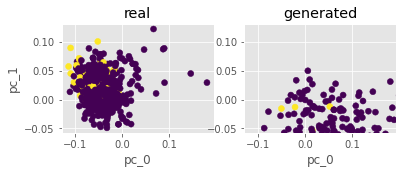

Step: 100 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0921, 0.0928, 0.0966, 0.8618
D Real - D Gen: 0.0038


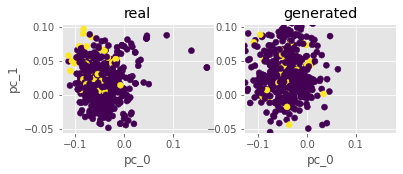

Step: 200 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0914, 0.0911, 0.0935, 0.8354
D Real - D Gen: 0.0025


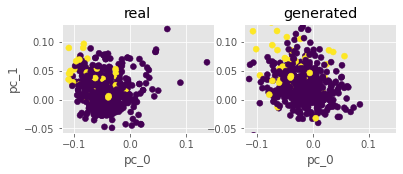

Step: 300 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0855, 0.0854, 0.0866, 0.8191
D Real - D Gen: 0.0012


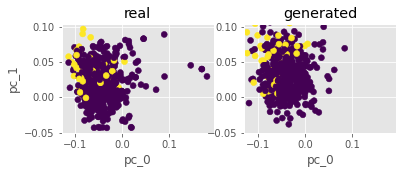

Step: 400 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0847, 0.0836, 0.0844, 0.8740
D Real - D Gen: 0.0008


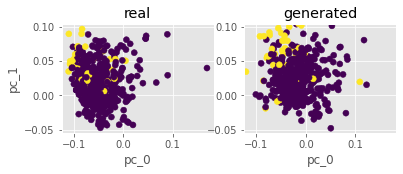

Step: 500 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0784, 0.0763, 0.0773, 0.8618
D Real - D Gen: 0.0009


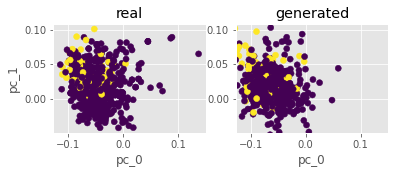

Step: 600 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0713, 0.0706, 0.0715, 0.8374
D Real - D Gen: 0.0008


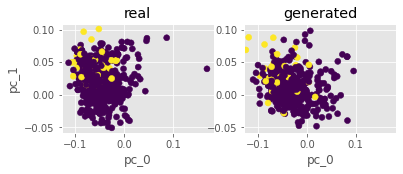

Step: 700 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0636, 0.0621, 0.0635, 0.8333
D Real - D Gen: 0.0015


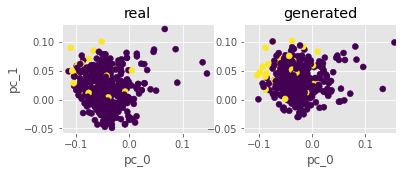

Step: 800 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0624, 0.0602, 0.0607, 0.8293
D Real - D Gen: 0.0006


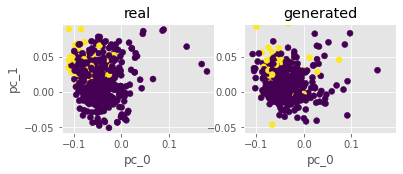

Step: 900 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0592, 0.0610, 0.0622, 0.8659
D Real - D Gen: 0.0011


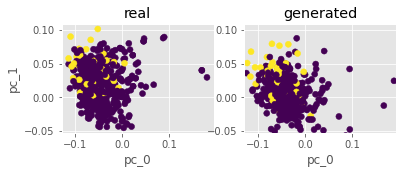

Step: 1000 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0558, 0.0567, 0.0580, 0.8333
D Real - D Gen: 0.0013


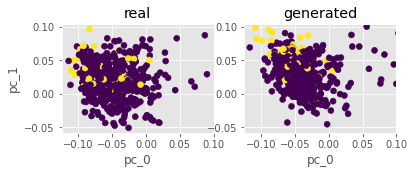

Step: 1100 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0574, 0.0550, 0.0553, 0.8801
D Real - D Gen: 0.0003


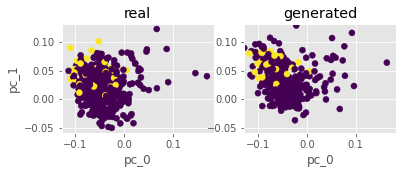

Step: 1200 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0462, 0.0470, 0.0475, 0.9411
D Real - D Gen: 0.0005


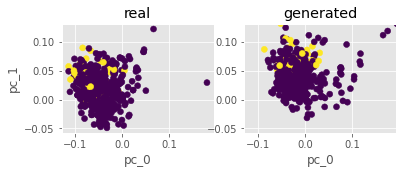

Step: 1300 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0491, 0.0488, 0.0502, 0.9106
D Real - D Gen: 0.0014


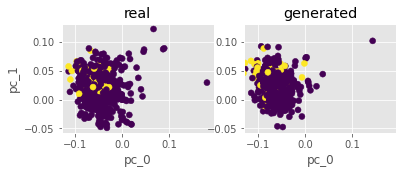

Step: 1400 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0421, 0.0407, 0.0424, 0.8394
D Real - D Gen: 0.0017


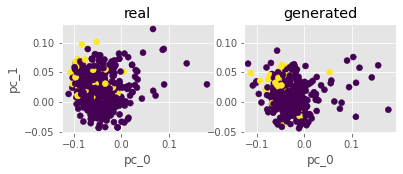

Step: 1500 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0410, 0.0414, 0.0424, 0.8130
D Real - D Gen: 0.0010


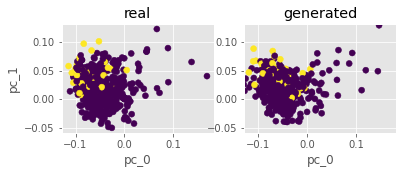

Step: 1600 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0440, 0.0441, 0.0448, 0.8821
D Real - D Gen: 0.0007


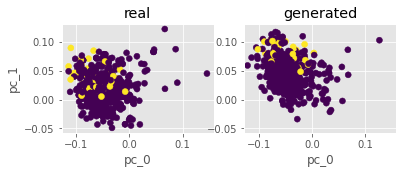

Step: 1700 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0493, 0.0490, 0.0501, 0.8679
D Real - D Gen: 0.0011


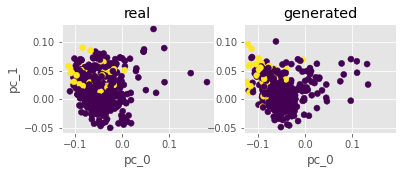

Step: 1800 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0455, 0.0455, 0.0466, 0.8150
D Real - D Gen: 0.0012


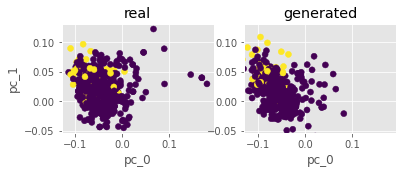

Step: 1900 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0406, 0.0403, 0.0408, 0.8638
D Real - D Gen: 0.0005


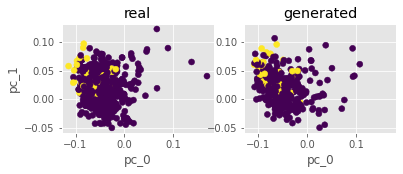

Step: 2000 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0406, 0.0424, 0.0431, 0.7825
D Real - D Gen: 0.0007


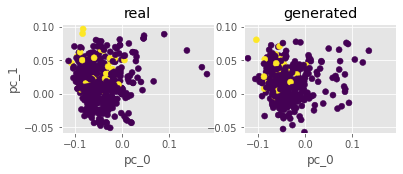

Step: 2100 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0491, 0.0480, 0.0481, 0.8455
D Real - D Gen: 0.0001


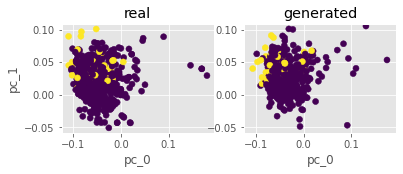

Step: 2200 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0448, 0.0451, 0.0457, 0.7012
D Real - D Gen: 0.0006


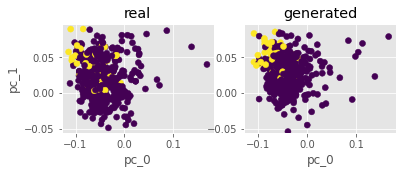

Step: 2300 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0465, 0.0467, 0.0472, 0.8516
D Real - D Gen: 0.0004


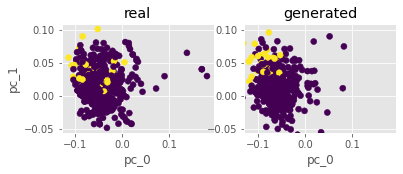

Step: 2400 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0345, 0.0352, 0.0354, 0.8720
D Real - D Gen: 0.0002


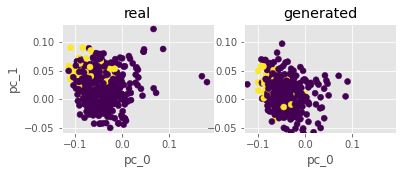

Step: 2500 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0351, 0.0337, 0.0343, 0.7378
D Real - D Gen: 0.0006


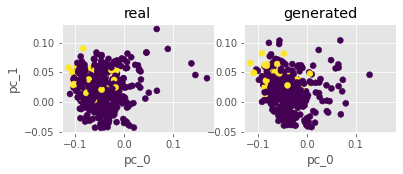

Step: 2600 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0304, 0.0322, 0.0332, 0.8130
D Real - D Gen: 0.0010


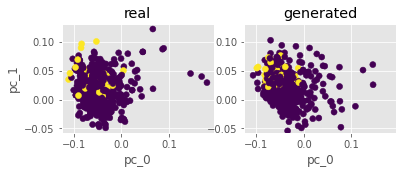

Step: 2700 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0314, 0.0311, 0.0315, 0.7541
D Real - D Gen: 0.0004


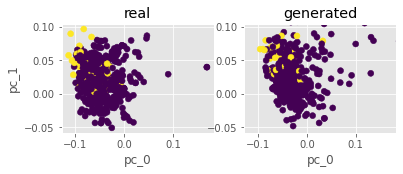

Step: 2800 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0292, 0.0294, 0.0295, 0.7419
D Real - D Gen: 0.0001


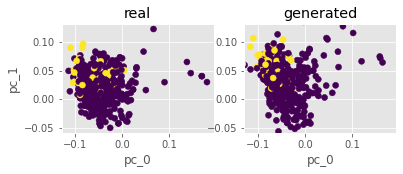

Step: 2900 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0321, 0.0320, 0.0332, 0.8150
D Real - D Gen: 0.0011


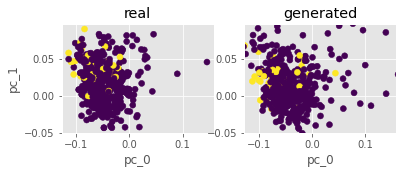

Step: 3000 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0308, 0.0304, 0.0311, 0.8516
D Real - D Gen: 0.0007


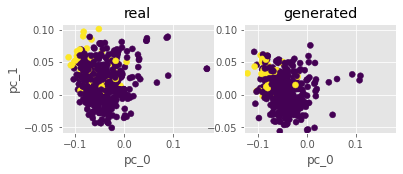

Step: 3100 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0265, 0.0290, 0.0291, 0.7907
D Real - D Gen: 0.0001


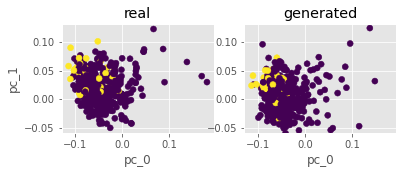

Step: 3200 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0213, 0.0224, 0.0229, 0.8455
D Real - D Gen: 0.0005


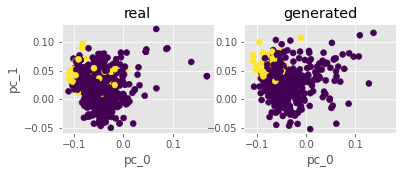

Step: 3300 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0240, 0.0241, 0.0245, 0.8272
D Real - D Gen: 0.0005


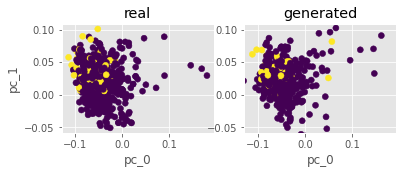

Step: 3400 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0269, 0.0257, 0.0261, 0.8211
D Real - D Gen: 0.0004


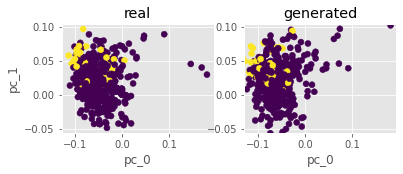

Step: 3500 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0231, 0.0236, 0.0238, 0.7520
D Real - D Gen: 0.0002


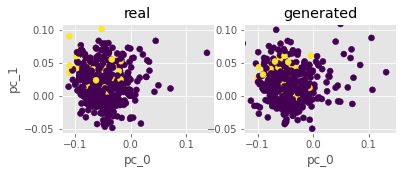

Step: 3600 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0227, 0.0223, 0.0225, 0.7073
D Real - D Gen: 0.0002


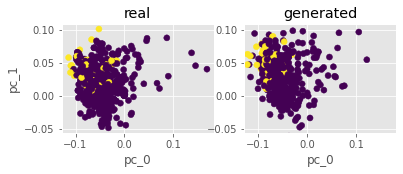

Step: 3700 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0166, 0.0162, 0.0164, 0.7093
D Real - D Gen: 0.0001


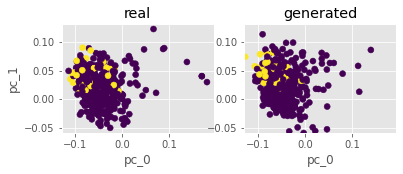

Step: 3800 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0245, 0.0242, 0.0248, 0.7907
D Real - D Gen: 0.0005


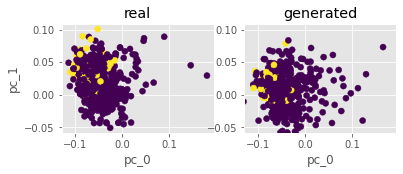

Step: 3900 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0266, 0.0266, 0.0268, 0.8374
D Real - D Gen: 0.0002


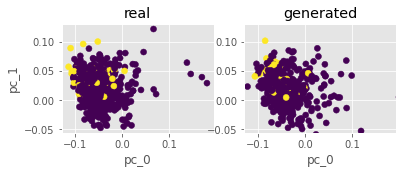

Step: 4000 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0300, 0.0302, 0.0304, 0.7398
D Real - D Gen: 0.0002


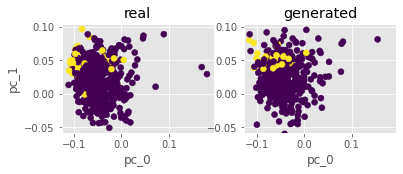

Step: 4100 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0352, 0.0356, 0.0361, 0.7520
D Real - D Gen: 0.0005


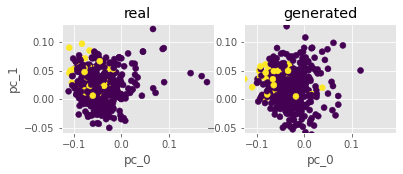

Step: 4200 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0308, 0.0327, 0.0335, 0.7276
D Real - D Gen: 0.0009


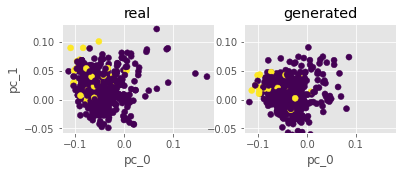

Step: 4300 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0324, 0.0334, 0.0336, 0.7236
D Real - D Gen: 0.0002


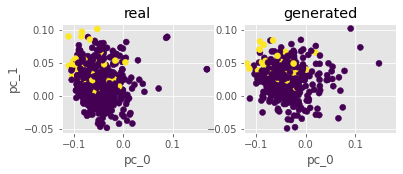

Step: 4400 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0360, 0.0349, 0.0357, 0.7114
D Real - D Gen: 0.0008


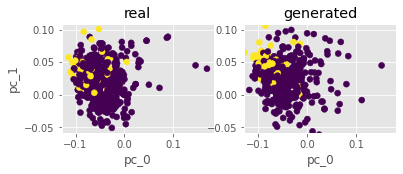

Step: 4500 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0304, 0.0296, 0.0288, 0.8191
D Real - D Gen: -0.0008


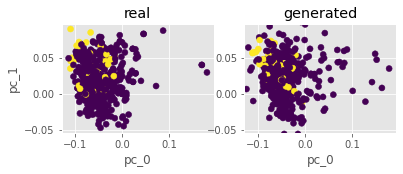

Step: 4600 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0289, 0.0294, 0.0296, 0.7053
D Real - D Gen: 0.0002


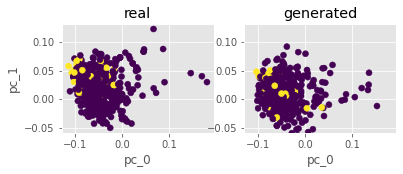

Step: 4700 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0286, 0.0286, 0.0289, 0.7195
D Real - D Gen: 0.0003


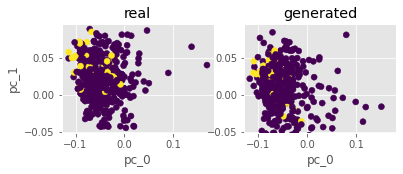

Step: 4800 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0248, 0.0251, 0.0253, 0.6382
D Real - D Gen: 0.0002


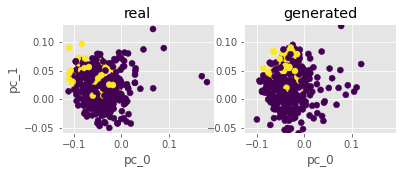

Step: 4900 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0280, 0.0294, 0.0297, 0.8028
D Real - D Gen: 0.0002


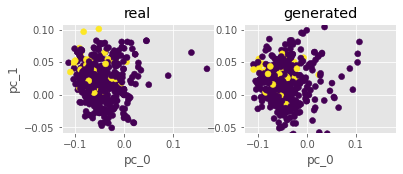

Step: 5000 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0315, 0.0316, 0.0320, 0.7053
D Real - D Gen: 0.0003


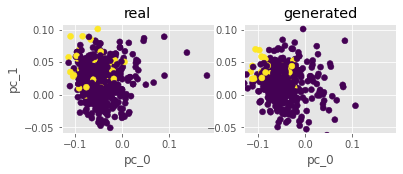

CPU times: user 33min 53s, sys: 19min 54s, total: 53min 47s
Wall time: 10min 45s


In [29]:
%%time

# Training the WGAN and WCGAN architectures

k_d = 5 # train critic to optimal state each time
learning_rate = 1e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols ) # WGAN
adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # WCGAN

3232 -0.0014435817
3100 -0.00083848834


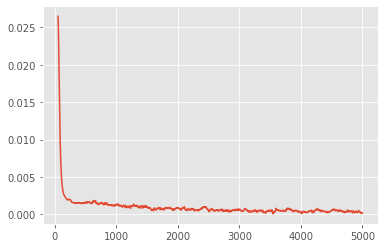

In [30]:

# For reloading loss data from pickles

prefix = 'WGAN'
step = 5000

[combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = pickle.load(
    open(data_dir+prefix+'_losses_step_'+str(step)+'.pkl','rb'))


# Look for the step with the lowest critic loss, and the lowest step saved (every 100)

delta_losses = np.array(disc_loss_real) - np.array(disc_loss_generated)

best_step = list(delta_losses).index( delta_losses.min() )
print( best_step, delta_losses.min() )

delta100 = [ delta_losses[i] for i in range(0, len(delta_losses), 100) ]
best_step = delta100.index( min(delta100) ) * log_interval
print( best_step, min(delta100) )


# plt.plot( (np.array(disc_loss_real) - np.array(disc_loss_generated)) )

w = 50
# plt.plot( list(range(0,5001,1)), pd.rolling_mean((np.array(disc_loss_real) - np.array(disc_loss_generated)),w) )
plt.plot( pd.DataFrame(disc_loss_real[:]).rolling(w).mean() - pd.DataFrame(disc_loss_generated[:]).rolling(w).mean() ) ;

# plt.xlim([9000,10000])
# plt.ylim([0.03,0.05])


4784 -0.0014616679
4500 -0.0008154977


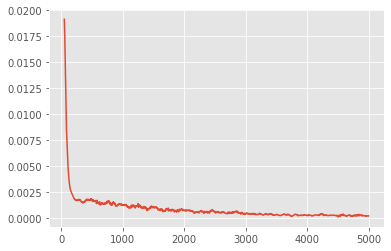

In [31]:

# For reloading loss data from pickles

prefix = 'WCGAN'
step = 5000

[combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = pickle.load(
    open(data_dir+prefix+'_losses_step_'+str(step)+'.pkl','rb'))


# Look for the step with the lowest critic loss, and the lowest step saved (every 100)

delta_losses = np.array(disc_loss_real) - np.array(disc_loss_generated)

best_step = list(delta_losses).index( delta_losses.min() )
print( best_step, delta_losses.min() )

delta100 = [ delta_losses[i] for i in range(0, len(delta_losses), 100) ]
best_step = delta100.index( min(delta100) ) * log_interval
print( best_step, min(delta100) )


# plt.plot( (np.array(disc_loss_real) - np.array(disc_loss_generated)) )

w = 50
# plt.plot( list(range(0,5001,1)), pd.rolling_mean((np.array(disc_loss_real) - np.array(disc_loss_generated)),w) )
plt.plot( pd.DataFrame(disc_loss_real[:]).rolling(w).mean() - pd.DataFrame(disc_loss_generated[:]).rolling(w).mean() ) ;

# plt.xlim([9000,10000])
# plt.ylim([0.03,0.05])


In [32]:
# Let's look at some of the generated data
# First create the networks locally and load the weights

import GANS
import importlib
importlib.reload(GANS) # For reloading after making changes
from GANS import *

seed = 42

train = failure_w_classes.copy().reset_index(drop=True) # failure only with labels from classification

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim = len(data_cols)
label_dim = len(label_cols)
with_class = False
if label_dim > 0: with_class = True
np.random.seed(seed)

# define network models

# generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
# generator_model.load_weights('cache/WCGAN_generator_model_weights_step_4800.h5')
generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
generator_model.load_weights('cache/WCGAN_generator_model_weights_step_5000.h5')


# with_class = False
# train = train_no_label
# label_cols = []
# # generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count, type='Wasserstein')
# # generator_model.load_weights('cache/WGAN_generator_model_weights_step_4800.h5')

# generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count)
# generator_model.load_weights('cache/GAN_generator_model_weights_step_5000.h5')

<module 'GANS' from '/Users/Yasmin/Google Drive/PythonCam/ScaniaImbalancedData/GANS.py'>

### Generate Data Here from learnet model

In [33]:

# Now generate some new data

test_size = 2000 # Equal to all of the fraud cases

x = get_data_batch(train, test_size, seed=i+j)
z = np.random.normal(size=(test_size, rand_dim))
if with_class:
    labels = x[:,-label_dim:]
    g_z = generator_model.predict([z, labels])
else:
    g_z = generator_model.predict(z)

0.769


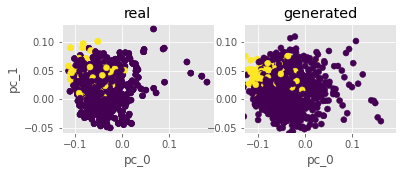

In [34]:
# Check using the same functions used during GAN training

print( CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim ) )

PlotData( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )

In [35]:
# Now we can train and test an xgboost classifier on our generated data
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score

real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
test_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
real_samples['syn_label'] = 0
test_samples['syn_label'] = 1

training_fraction = 0.5
n_real, n_test = int(len(real_samples)*training_fraction), int(len(test_samples)*training_fraction)
train_df = pd.concat([real_samples[:n_real],test_samples[:n_test]],axis=0)
test_df = pd.concat([real_samples[n_real:],test_samples[n_test:]],axis=0)

# X_col = test_df.columns[:-(label_dim+1)]
X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)
y_true = test_df['syn_label']

# dtrain = np.vstack( [ x[:int(len(x)/2)], g_z[:int(len(g_z)/2)] ] )
# dlabels = np.hstack( [ np.zeros(int(len(x)/2)), np.ones(int(len(g_z)/2)) ] )
# dtest = np.vstack( [ x[int(len(x)/2):], g_z[int(len(g_z)/2):] ] )

# dtrain = xgb.DMatrix(dtrain, dlabels, feature_names=data_cols+label_cols)
# dtest = xgb.DMatrix(dtest, feature_names=data_cols+label_cols)
# y_true = dlabels

xgb_params = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': random_state,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes 
}
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred = np.round(xgb_test.predict(dtest))

print( '{:.2f}'.format(SimpleAccuracy(y_pred, y_true)) )
print( '{:.2f}'.format(f1_score(y_true, y_pred)))
print( '{:.2f}'.format(precision_score(y_true, y_pred)))
print( '{:.2f}'.format(recall_score(y_true, y_pred)))

0.77
0.74
0.84
0.67


In [36]:
# Evaluate performance on validation set

SimpleMetrics(y_pred,y_true)

Confusion Matrix


Pred 0  Pred 1
True 0  870     130   
True 1  332     668

Accuracy : 0.769
Cost: 167300


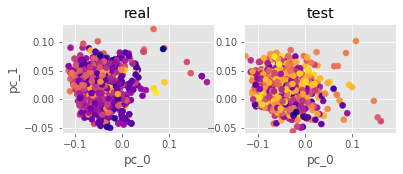

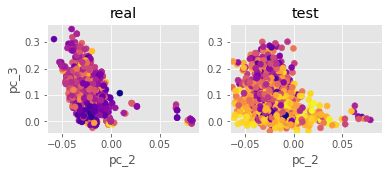

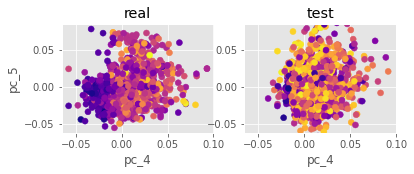

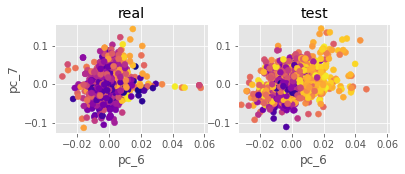

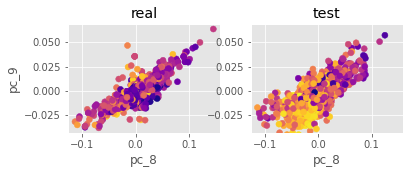

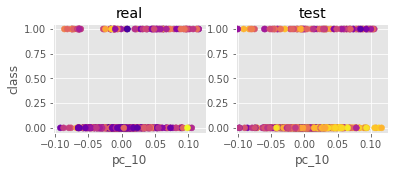

In [37]:

# Let's look at how the discrimnator scored real and generated data, visualized along every feature

y_pred0 = xgb_test.predict(dtest)

for i in range(0,len(X_col)-1, 2):

    f, axarr = plt.subplots(1, 2, figsize=(6,2) )

    axarr[0].scatter( test_df[:n_real][X_col[i]], test_df[:n_real][X_col[i+1]], c=y_pred0[:n_real], cmap='plasma'  )
    axarr[0].set_title('real')
    axarr[0].set_ylabel(X_col[i+1])

    axarr[1].scatter( test_df[n_real:][X_col[i]], test_df[n_real:][X_col[i+1]], c=y_pred0[n_real:], cmap='plasma'  )
    axarr[1].set_title('test')
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim())

    for a in axarr:
        a.set_xlabel(X_col[i])

    plt.show()
pass;

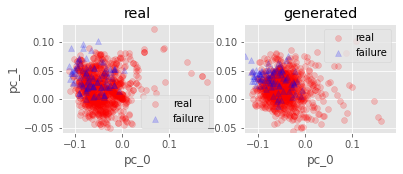

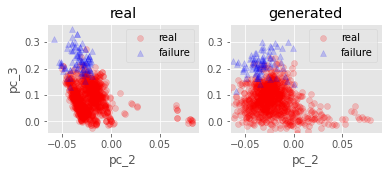

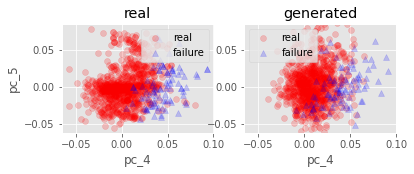

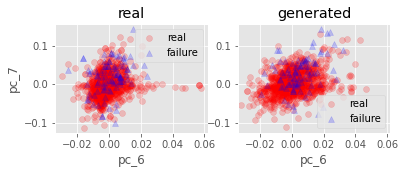

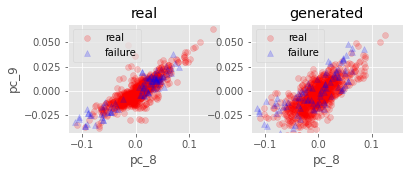

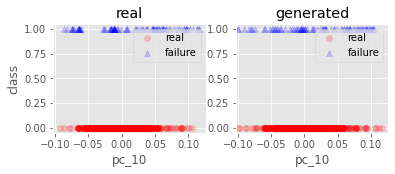

In [38]:

# Now we can compare the real and generated data by class, along every feature

colors = ['red','blue']
markers = ['o','^']
labels = ['real','failure']

class_label = 'class'

for i in range(0,len(X_col), 2):
    col1, col2 = i, i+1
    if i+1 >= len(X_col): continue
    
    f, axarr = plt.subplots(1, 2, figsize=(6,2) )
    for group, color, marker, label in zip( test_df[:n_real].groupby(class_label), colors, markers, labels ):
        axarr[0].scatter( group[1][X_col[col1]], group[1][X_col[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    axarr[0].legend()
    axarr[0].set_title('real')
    axarr[0].set_ylabel(X_col[col2])

    for group, color, marker, label in zip( test_df[n_real:].groupby(class_label), colors, markers, labels ):
        axarr[1].scatter( group[1][X_col[col1]], group[1][X_col[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim())
    axarr[1].legend()
    axarr[1].set_title('generated') ;

    for a in axarr:
        a.set_xlabel(X_col[col1])

    plt.show()
pass;

In [39]:

# Evaluate performance on validation set

SimpleMetrics(y_pred,y_true)

Confusion Matrix


Pred 0  Pred 1
True 0  870     130   
True 1  332     668

Accuracy : 0.769
Cost: 167300


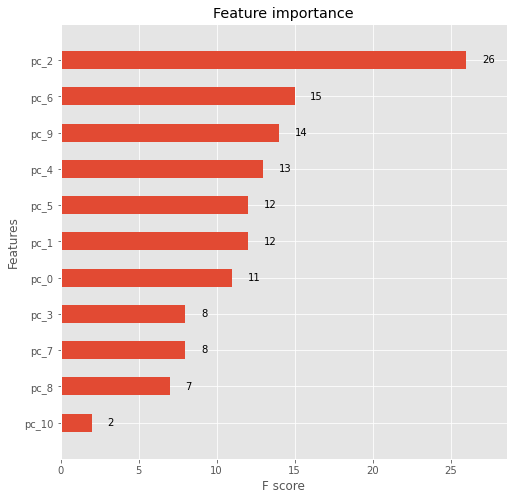

In [40]:

# Plot feature importances used for identifying generated data

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=20, height=0.5, ax=ax);

### Compare WGAN Vs WCGAN Output


It may be best to restart the notebook, run the setup section, and then run this section


In [41]:

# Set up the training dataset

train = failure_w_classes.copy().reset_index(drop=True) # fraud only with labels from classification

train = pd.get_dummies(train, columns=['class'], prefix='class', drop_first=True)
label_cols = [ i for i in train.columns if 'class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim = len(data_cols)
label_dim = len(label_cols)

In [42]:

seed = 42
test_size = 1000 # number of fraud cases

np.random.seed(seed)
z = np.random.normal(size=(test_size, rand_dim))
x = get_data_batch(train, test_size, seed=seed)
real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
labels = x[:,-label_dim:]

# colors = ['C1','C9']
# colors = ['xkcd:plum', 'xkcd:navy']
colors = ['red','blue']
markers = ['o','^']
class_labels = ['Class 1','Class 2']

col1, col2 = 'pc_1', 'pc_2'

#base_dir = 'cache lr mix base 128 act mix 171026/'
base_dir = 'cache/'


In [43]:
# Generate empty models

rand_dim = 11
base_n_count = 128
model_names = ['WGAN','WCGAN']
with_classes = [False, True]
type0s = ['Wasserstein', 'Wasserstein']

models = {}

for model_name, with_class, type0 in zip(model_names, with_classes, type0s ):

    if with_class:
        generator_model, discriminator_model, combined_model = \
            define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type=type0)
    else:
         generator_model, discriminator_model, combined_model = \
            define_models_GAN(rand_dim, data_dim, base_n_count, type=type0)   
    
    models[model_name] = [ model_name, with_class, type0, generator_model ]

## Comparison of GAN outputs


1000
2000
3000
4000
5000


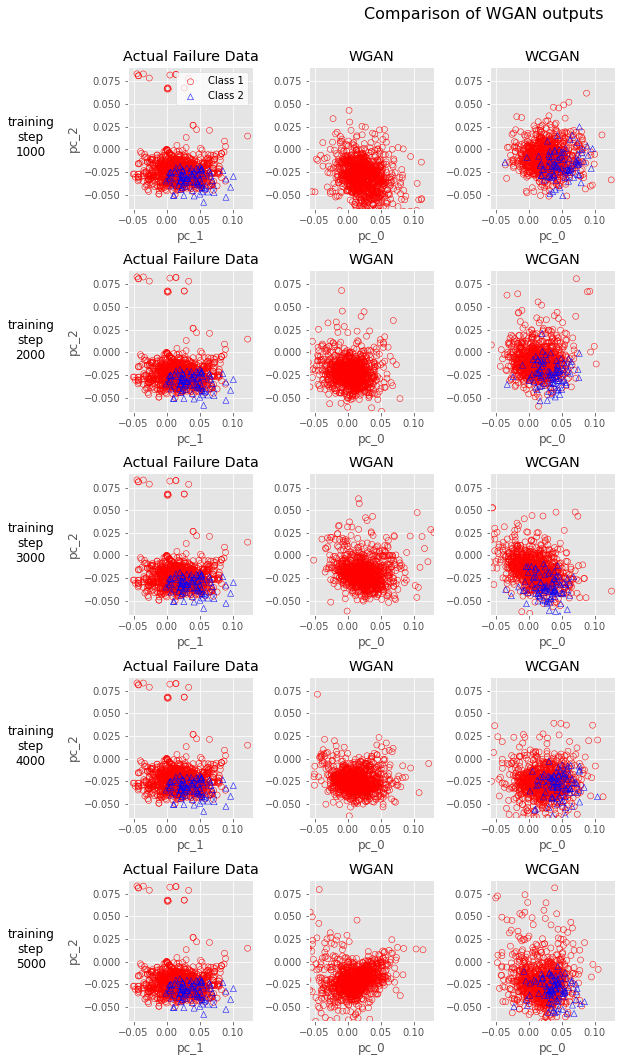

In [44]:


# model_steps = [500, 5000]
# model_steps = [ 0, 100, 200, 500, 1000 ]
#model_steps = [ 0, 100, 200, 500, 1000, 2000, 5000]
#model_steps = [ 0, 100, 200, 500]
model_steps = [ 1000, 2000, 3000, 4000, 5000]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate( model_steps ):
    print(model_step)
        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker, label in zip( real_samples.groupby('class_1'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]], 
                         label=label, marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Failure Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
        
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    for i, model_name in enumerate( model_names[:] ):
        
        [ model_name, with_class, type0, generator_model ] = models[model_name]
        
        generator_model.load_weights( base_dir + model_name + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )
        
        if with_class:
            g_z = generator_model.predict([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
            for group, color, marker, label in zip( gen_samples.groupby('class_1'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]], 
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model.predict(z)
            gen_samples = pd.DataFrame(g_z, columns=data_cols)
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]], 
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(data_cols[0])
        ax.set_xlim(xlims), ax.set_ylim(ylims)


plt.suptitle('Comparison of WGAN outputs', size=16)
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

plt.savefig('cache/Comparison_of_WGAN_CWGAN_outputs.png')
pass;

<a id="Generated Data Testing"><h1>Generated Data Testing</h1></a>

<a href='#TOC'>Table of contents</a>

In [45]:

# Setup xgboost parameters

xgb_params = {
#     'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': random_state,
    'eval_metric': 'auc', # auc, error
#     'tree_method': 'hist'
#     'grow_policy': 'lossguide' # depthwise, lossguide
}

# https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py

from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)

def f1_s(preds, dtrain):
    labels = dtrain.get_label()
    return 'f1_s',  f1_score(labels, preds)


In [46]:

# Define model parameters

seed = 42
np.random.seed(seed)

data_dim = len(data_cols)
label_dim = len(label_cols)

#base_dir = 'cache lr mix base 128 act mix 171026/'
base_dir = 'cache/'
rand_dim = 11
base_n_count = 128


In [47]:

# # defined training set parameters

# train_fraction = 0.7
# X_col = data.columns[:-1]
# y_col = data.columns[-1]

# folds = 5


**WGAN**

In [48]:
%%time

# Generate and test data with trained model

generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count, type='Wasserstein')
#generator_model.load_weights( base_dir + 'WCGAN_generator_model_weights_step_4800.h5')
generator_model.load_weights( base_dir + 'WGAN_generator_model_weights_step_5000.h5')

g_z_df =pd.DataFrame()
seeds = [i for i in range(100)]
# generate 58000
for i in range (0, 58):
    test_size = 1000

    x = get_data_batch(train, test_size, seed=seeds[i])
    z = np.random.normal(size=(test_size, rand_dim))
    #labels = x[:,-label_dim:]
    #g_z = generator_model.predict([z, labels])
    g_z = generator_model.predict(z)



    # The labels for the generate data will all be 1, as they are supposed to be fraud data
    g_z_df_ = pd.DataFrame( np.hstack( [g_z[:,:len(data_cols)], np.ones((len(g_z),1))] ), columns=data_cols+["class" ])
    g_z_df = pd.concat([g_z_df, g_z_df_])

g_z_df.to_csv("ScaniaDataset/WGAN_Scania.csv", index=False)

CPU times: user 3.38 s, sys: 254 ms, total: 3.64 s
Wall time: 3.21 s


**WCGAN**

In [49]:
%%time

# Generate and test data with trained model

generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
#generator_model.load_weights( base_dir + 'WCGAN_generator_model_weights_step_4800.h5')
generator_model.load_weights( base_dir + 'WCGAN_generator_model_weights_step_5000.h5')

g_z_df =pd.DataFrame()
seeds = [i for i in range(100)]
# generate 58000
for i in range (0, 58):
    test_size = 1000

    x = get_data_batch(failure_w_classes, test_size, seed=seeds[i])
    z = np.random.normal(size=(test_size, rand_dim))
    labels = x[:,-label_dim:]
    g_z = generator_model.predict([z, labels])



    # The labels for the generate data will all be 1, as they are supposed to be fraud data
    g_z_df_ = pd.DataFrame( np.hstack( [g_z[:,:len(data_cols)], np.ones((len(g_z),1))] ), columns=data_cols+["class" ])
    g_z_df = pd.concat([g_z_df, g_z_df_])

g_z_df.to_csv("ScaniaDataset/WCGAN_Scania.csv", index=False)

CPU times: user 3.49 s, sys: 270 ms, total: 3.76 s
Wall time: 3.33 s


In [50]:
len(g_z_df)
len(g_z_df.drop_duplicates())
g_z_df.head()

58000

58000

pc_0      pc_1      pc_2      pc_3      pc_4      pc_5      pc_6      pc_7      pc_8      pc_9     pc_10  class
0 -0.086379  0.035103 -0.027553  0.109741  0.008550 -0.022199  0.003587  0.011403 -0.054875 -0.021835 -0.027067  1.0  
1 -0.079028  0.001684 -0.011238  0.080636  0.009661 -0.019761  0.016570  0.042554 -0.046781 -0.029835  0.053438  1.0  
2 -0.047974 -0.004304 -0.021278  0.108282  0.012503 -0.002878  0.004666  0.016307 -0.108827 -0.030280 -0.035488  1.0  
3 -0.045045  0.029315 -0.030062  0.020079 -0.013335  0.012087  0.007167 -0.000274 -0.006133 -0.001939  0.000007  1.0  
4 -0.076848  0.023261 -0.025862  0.227883  0.050770 -0.000193 -0.021034 -0.006826  0.059138  0.019691  0.079651  1.0

In [51]:
len(g_z_df)
g_z_df.head()

58000

pc_0      pc_1      pc_2      pc_3      pc_4      pc_5      pc_6      pc_7      pc_8      pc_9     pc_10  class
0 -0.086379  0.035103 -0.027553  0.109741  0.008550 -0.022199  0.003587  0.011403 -0.054875 -0.021835 -0.027067  1.0  
1 -0.079028  0.001684 -0.011238  0.080636  0.009661 -0.019761  0.016570  0.042554 -0.046781 -0.029835  0.053438  1.0  
2 -0.047974 -0.004304 -0.021278  0.108282  0.012503 -0.002878  0.004666  0.016307 -0.108827 -0.030280 -0.035488  1.0  
3 -0.045045  0.029315 -0.030062  0.020079 -0.013335  0.012087  0.007167 -0.000274 -0.006133 -0.001939  0.000007  1.0  
4 -0.076848  0.023261 -0.025862  0.227883  0.050770 -0.000193 -0.021034 -0.006826  0.059138  0.019691  0.079651  1.0

<a id="Summary"><h1>Summary of Training Data</h1></a>



In [52]:

# Load the saved loss data from each model

# base_dir = 'cache/'
base_dir = 'cache/'

suffix = '_step_5000'

WGAN_losses = pickle.load(open(base_dir + 'WGAN_losses'+suffix+'.pkl','rb'))
WCGAN_losses = pickle.load(open(base_dir + 'WCGAN_losses'+suffix+'.pkl','rb'))


FileNotFoundError: [Errno 2] No such file or directory: 'cache/GAN_losses_step_5000.pkl'

In [ ]:

# Look at the unsmoothed losses

data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_', 'xgb_losses']
sampling_intervals = [ 1, 1, 1, 10 ]
labels = [ 'GAN','CGAN']
linestyles = ['-', '--']

for data_ix in range(len(data_fields)):
    data_sets = [ WGAN_losses[data_ix], WCGAN_losses[data_ix]]

    plt.figure(figsize=(10,5))
    for data, label, linestyle in zip(data_sets, labels, linestyles):
        plt.plot( np.array(range(0,len(data)))*sampling_intervals[data_ix],
                 data,
                 label=label, linestyle=linestyle )

    plt.ylabel(data_fields[data_ix])
    plt.xlabel('training step')
    plt.legend()
    plt.show()


<Figure size 720x360 with 0 Axes>

Text(0, 0.5, 'combined_losses_')

Text(0.5, 0, 'training step')

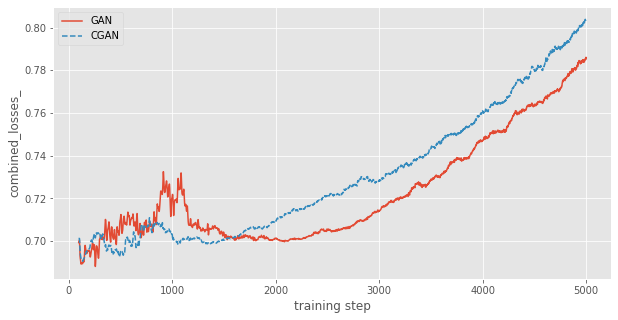

<Figure size 720x360 with 0 Axes>

Text(0, 0.5, 'real_losses_')

Text(0.5, 0, 'training step')

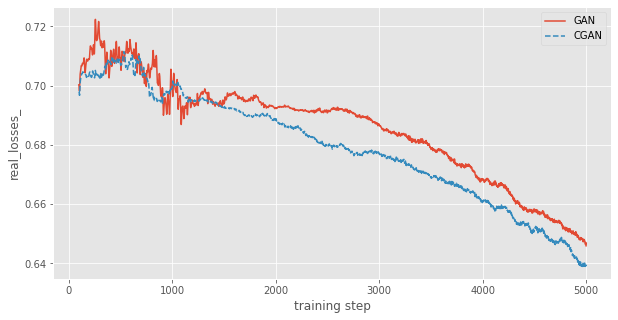

<Figure size 720x360 with 0 Axes>

Text(0, 0.5, 'generated_losses_')

Text(0.5, 0, 'training step')

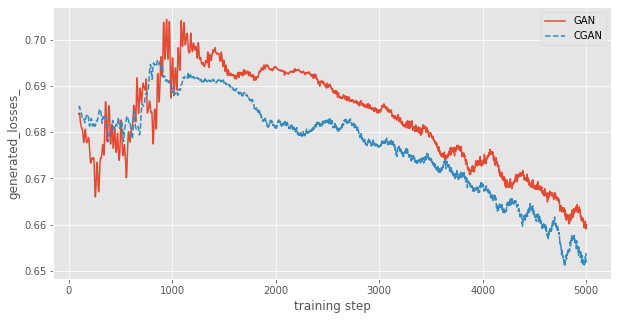

<Figure size 720x360 with 0 Axes>

Text(0, 0.5, 'xgb_losses')

Text(0.5, 0, 'training step')

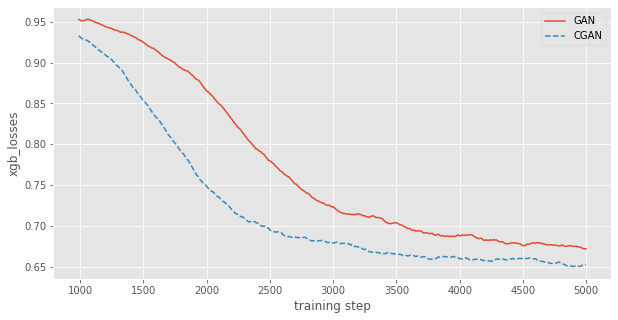

In [55]:

# Look at the smoothed losses

data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_', 'xgb_losses']
sampling_intervals = [ 1, 1, 1, 10 ]
labels = [ 'WGAN','WCGAN' ]
linestyles = ['-', '--']

w = 100
for data_ix in range(len(data_fields)):
    data_sets = [ WGAN_losses[data_ix], WCGAN_losses[data_ix]]

    plt.figure(figsize=(10,5))
    for data, label, linestyle in zip(data_sets, labels, linestyles):
        plt.plot( np.array(range(0,len(data)))*sampling_intervals[data_ix],
                 pd.DataFrame(data).rolling(w).mean(),
                 label=label, linestyle=linestyle )

    plt.ylabel(data_fields[data_ix])
    plt.xlabel('training step')
    plt.legend()
    plt.show()


### Figure 7: Differences in Critic Loss

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Difference between critic loss (EM distance estimate)\non generated samples and real samples')

Text(0.5, 0, 'training step')

Text(0, 0.5, 'Gen - Real Critic Loss')

No handles with labels found to put in legend.


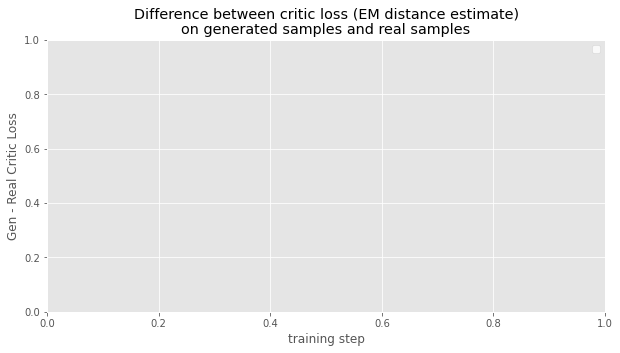

In [56]:

# Create a figure for the critic losses for the WGAN and WCGAN

w = 50

data_ix0 = 2
data_ix1 = 1
data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_', 'xgb_losses']

i1, i2 = 2, 3
i2 += 1

labels = [ 'WGAN','WCGAN'][i1:i2]
data_sets0 = [ WGAN_losses[data_ix0], WCGAN_losses[data_ix0]][i1:i2]
data_sets1 = [ WGAN_losses[data_ix1], WCGAN_losses[data_ix1]][i1:i2]
linestyles = ['-', '--', '-.', ':'][i1:i2]

plt.figure(figsize=(10,5))
for data0, data1, label, linestyle in zip(data_sets0, data_sets1, labels, linestyles):
    plt.plot( range(0,len(data0)), 
             pd.DataFrame( np.array(data0)-np.array(data1) ).rolling(w).mean(),  
             label=label, linestyle=linestyle )
plt.title('Difference between critic loss (EM distance estimate)\non generated samples and real samples')
plt.xlabel('training step')
plt.ylabel('Gen - Real Critic Loss')
legend = plt.legend() 
legend.get_frame().set_facecolor('white')
# plt.savefig('plots/Delta_critic_loss_plot.png')